# Attack

### Preliminaries 
#### (algorithms => `mean`; `standard deviation`; `covariance`; `hamming weight` and `Pearson Correlation Coefficient`)

In [1]:
# if not imported...
try:
    import numpy as np
except:
    pass

# Important!: this value must represent the bytes to be cracked in the attack scenario
#####################
# usage in HW, maxcpa, ranges
bytesToProcedure = 256
#####################

# mean; to calculate the mean of a dataset (numpy optimised)
def mean(X):
    return np.sum(X, axis=0)/len(X)

def mean_np(X):
    return np.mean(X, axis=0)

''' # example code for testing
a = np.array([[5, 3, 4, 4, 5, 6],
             [27, 2, 3, 4, 12, 6],
              [1, 3, 5, 4, 5, 6],
              [1, 2, 3, 4, 5, 6],
             ]).transpose()
a_bar = mean(a)

b = np.array([[5, 4, 3, 2, 1, 3]]).transpose()
b_bar = mean(b)
'''

# standard deviation (numpy optimised)
def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def std_np(X):
    return np.std(X)

'''
o_a = std_dev(a, a_bar)
o_b = std_dev(b, b_bar)
'''

# covariance (numpy optimised)
def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

def cov_np(X, Y):
    return np.cov(X, y=Y)

'''
ab_cov = cov(a, a_bar, b, b_bar)
'''

# hamming weight, pre-calculate => only works for the implemented range
HW = [bin(n).count("1") for n in range(0, 256)]

# hamming weight fast calculation
def hw(x):
    x -= (x >> 1) & 0x5555555555555555
    x = (x & 0x3333333333333333) + ((x >> 2) & 0x3333333333333333)
    x = (x + (x >> 4)) & 0x0f0f0f0f0f0f0f0f
    return ((x * 0x0101010101010101) & 0xffffffffffffffff) >> 56

# hamming weight numpy compatible
def hw_np(x):
    x -= (x >> 1) & 0x5555555555555555
    x = (x & 0x3333333333333333) + ((x >> 2) & 0x3333333333333333)
    x = (x + (x >> 4)) & 0x0f0f0f0f0f0f0f0f
    return (x * 0x0101010101010101) >> 56

''' # hamming weight benchmark
import time
st = time.time()
for _ in range(1000000):
    assert HW[7] == 3
print(time.time() - st)
# ~ 0.0921471118927002

st = time.time()
for _ in range(1000000):
    assert hw(7) == 3
print(time.time() - st)
# ~ 0.8255484104156494
'''


# fast Pearson Correlation Coefficient calculation
# (c) Prof. Dr. Jungk, HS-AlbSig
def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);

    # Finally get corr coeff
    return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None])) 

### Get traces from hardware or use files

In [2]:
# fresh measurement
#print("Measurement begin")
#%run 'ChaCha20-MEASURE.ipynb'
#print("Measurement end")

# use measured and saved traces
trace_array = np.load('trace_array15000-shuffled.npy')
nc_array = np.load('nc_array15000-shuffled.npy')

ntraces = len(trace_array)

In [3]:
print(len(trace_array))
print(len(nc_array))
print(trace_array)
print(nc_array)

15000
15000
[[-0.0078125  -0.20117188 -0.15039062 ... -0.00488281  0.0390625
   0.04199219]
 [-0.00878906 -0.203125   -0.14941406 ... -0.22753906 -0.13867188
  -0.10253906]
 [-0.0078125  -0.19726562 -0.1484375  ...  0.05371094  0.08691406
   0.08007812]
 ...
 [-0.00683594 -0.20898438 -0.15136719 ... -0.02636719  0.02441406
   0.02929688]
 [-0.01074219 -0.21191406 -0.15429688 ...  0.02441406  0.0625
   0.06152344]
 [-0.00683594 -0.21191406 -0.15136719 ...  0.03808594  0.07617188
   0.07617188]]
[[200  61 175 ... 123 140 118]
 [ 86 125  10 ... 196 198  26]
 [241 177 154 ... 178 123 165]
 ...
 [253 241 203 ... 164 103 235]
 [175 248 135 ... 166 198 128]
 [112 207 144 ... 198 255 184]]


In [4]:
import struct
import random

# helper functions
def rotate_bits(s, offset):
    state_with_leading_zeros = '{:032b}'.format(s)
    return int(state_with_leading_zeros[offset:] + state_with_leading_zeros[:offset], 2)


def add_mod_2_pow32(left_summand, right_summand):
    return (left_summand + right_summand) % 2 ** 32


def bitwise_xor(left_bytes, right_bytes):
    return left_bytes ^ right_bytes


def chacha20_quarterround(s: list, a, b, c, d):
    s[a] = add_mod_2_pow32(s[a], s[b])

    s[d] = bitwise_xor(s[d], s[a])
    # place to get first part of key
    #hw_l.append(hw(s[d]))#.to_bytes(4, byteorder='little')[0]) # => this is the point to attack; but then len 8000 
    #print(bin(s[d])) # print binary output to proof output of attack model
    s[d] = rotate_bits(s[d], 16)

    s[c] = add_mod_2_pow32(s[c], s[d])
    # müsste ebenfalls schon gehen
    s[b] = bitwise_xor(s[b], s[c])
    # place to get second part of Key
    #print(bin(s[b]))
    s[b] = rotate_bits(s[b], 12)

    s[a] = add_mod_2_pow32(s[a], s[b])
    s[d] = bitwise_xor(s[d], s[a])
    s[d] = rotate_bits(s[d], 8)

    s[c] = add_mod_2_pow32(s[c], s[d])
    s[b] = bitwise_xor(s[b], s[c])
    s[b] = rotate_bits(s[b], 7)


def chacha20_block(state):
    s = state.copy()
    for _ in range(10):
        
        # column rounds
        #  hiding with shuffling the sequence for each round
        #  works for both, column and diagonal round
        r = [0, 1, 2, 3]
        random.shuffle(r)
        for i in r:
            chacha20_quarterround(s, i, i+4, i+8, i+12)
        #chacha20_quarterround(s, 0, 4, 8, 12)
        #chacha20_quarterround(s, 1, 5, 9, 13)
        #chacha20_quarterround(s, 2, 6, 10, 14)
        #chacha20_quarterround(s, 3, 7, 11, 15)

        # diagonal rounds
        r = [0, 1, 2, 3]
        random.shuffle(r)
        for i in r:
            if i == 0:
                chacha20_quarterround(s, 0, 5, 10, 15)
            elif i == 1:
                chacha20_quarterround(s, 1, 6, 11, 12)
            elif i == 2:
                chacha20_quarterround(s, 2, 7, 8, 13)
            elif i == 3:
                chacha20_quarterround(s, 3, 4, 9, 14)

    # modular additions
    for h in range(16):
        state[h] = add_mod_2_pow32(state[h], s[h])

    # alias ChaCha20 serialize
    result = bytes()
    for h in range(16):
        result += int.to_bytes(state[h], 4, 'little')
    return result


def ChaCha20XOR(state, input_text, count):
    input_text_length = len(input_text)
    k = chacha20_block(state)
    while len(k) < input_text_length:
        k += chacha20_block(state)
        count += 1
    return bytes(a ^ b for a, b in zip(k[:input_text_length], input_text))


def crypt(key, nonce, counter, inp):
    state = [0] * 16
    if len(key) != 32:
        raise ValueError('Invalid key length')
    if len(nonce) != 12:
        raise ValueError('Invalid nonce length')

    # Initialize constants
    state[0] = 0x61707865
    state[1] = 0x3320646e
    state[2] = 0x79622d32
    state[3] = 0x6b206574

    # Initialize key fields
    # use struct.unpack() => '<8L' == little endian (<) 8 (<8) times unsigned long int (<8L) (32bit uint)
    state[4:12] = struct.unpack('<8L', bytes(key))

    # Initialize counter
    state[12] = int.from_bytes(counter, byteorder='little')

    # Initialize nonce
    # use struct.unpack() => '<3L' == 3 times unsigned long int (32bit uint)
    state[13:16] = struct.unpack('<3L', bytes(nonce))

    return ChaCha20XOR(state, inp, counter)

#########################################################################


if __name__ == "__main__":
    key = [0x00, 0x01, 0x02, 0x03, 0x04, 0x05, 0x06, 0x07,
           0x08, 0x09, 0x0a, 0x0b, 0x0c, 0x0d, 0x0e, 0x0f,
           0x10, 0x11, 0x12, 0x13, 0x14, 0x15, 0x16, 0x17,
           0x18, 0x19, 0x1a, 0x1b, 0x1c, 0x1d, 0x1e, 0x1f]

    inp = [0x48, 0x65, 0x6c, 0x6c, 0x6f, 0x20, 0x66, 0x72,
           0x6f, 0x6d, 0x20, 0x43, 0x68, 0x69, 0x70, 0x77,
           0x68, 0x69, 0x73, 0x70, 0x65, 0x72, 0x65, 0x72,
           0x65, 0x72, 0x2c, 0x20, 0x49, 0x6d, 0x20, 0x6f,
           0x6e, 0x6c, 0x79, 0x20, 0x68, 0x65, 0x72, 0x65,
           0x20, 0x74, 0x6f, 0x20, 0x67, 0x65, 0x74, 0x20,
           0x65, 0x6e, 0x63, 0x72, 0x79, 0x70, 0x74, 0x65,
           0x64, 0x20, 0x61, 0x6e, 0x64, 0x20, 0x79, 0x6f]
    
    nc = [0x01, 0x00, 0x00, 0x00, 
          0x00, 0x00, 0x00, 0x00, 
          0x00, 0x00, 0x00, 0x10, 
          0x00, 0x00, 0x00, 0xaa]
    
    ciphertext = crypt(key, nc[4:], nc[:4], inp)
    
    for i, byte in enumerate(ciphertext):
        print(f'{byte:02x}', end=' ')
        if not (i % 16) and i != 0:
            print()    
    print("\n")
    cleartext = crypt(key, nc[4:], nc[:4], ciphertext)
    
    for i, byte in enumerate(cleartext):
        print(f'{byte:02x}', end=' ')
        if not (i % 16) and i != 0:
            print()    

f0 af 4a 68 a9 6d ba d5 e6 36 e9 02 c6 e3 9b 89 43 
26 1c 5f c3 1d ef a1 a4 bf c0 3b d6 ec 10 3b d1 
76 ab 9b c0 3a 14 8c fd 84 ec 95 ab e5 af 45 75 
1e ed 8a df 96 6b 7c 31 86 a3 48 16 86 32 9e 

48 65 6c 6c 6f 20 66 72 6f 6d 20 43 68 69 70 77 68 
69 73 70 65 72 65 72 65 72 2c 20 49 6d 20 6f 6e 
6c 79 20 68 65 72 65 20 74 6f 20 67 65 74 20 65 
6e 63 72 79 70 74 65 64 20 61 6e 64 20 79 6f 

## Attack modell

### First 128 Bit of key

In [5]:
# correct key hypothesis should show first part of Key (RFC-Paper)
def round_part1(a,b,d):
    a = add_mod_2_pow32(a, b)
    d = bitwise_xor(d, a)
    return d

In [6]:
# alternative implementation (should be faster)
def round_part1(constant, key0, nc):
    a = (constant + key0) & 0xFFFFFFFF
    d = (nc ^ a)
    return d

In [7]:
# Example for the first key-byte
# Have a look at first binary output of ChaCha20 Model => LSB
rp1out = round_part1(0x61, 0x03, 0x00)
print(bin(rp1out))
print(f'{rp1out:02x}')

0b1100100
64


### Second 128 Bit of key

In [ ]:
# correct key hypothesis should give second part of Key
def round_part2(a,b,c,d):
    # perform the modular addition from round_part1, 
    # otherwise the value only contains the key part, not the constant part
    # here the output is changed to b, because it is needed 
    # and mod addition is commutative
    a = add_mod_2_pow32(a, b)
    # also d changes with the XOR, so calculate it again
    d = bitwise_xor(d, a)

    #d = rotate_bits(round_part1(a,b,d), 16)
    #d = rotate_bits(d, 16)
    d1 = ((d >> 16) | (d << 16)) & 0xFFFFFFFF
    
    c = add_mod_2_pow32(c, d1)
    b = np.bitwise_xor(b, c)
    return b

In [ ]:
# Warning!: output equal to the one above, but output when used is another...
# alternative faster implementation
'''
def round_part2(constant, key0, key1, nc):
    # ~ round_part1
    nc = ( (constant + key0) & 0xFFFFFFFF ) ^ nc

    # bitwise 16 byte shift left :D 
    nc = ((d >> 16) | (d << 16)) & 0xFFFFFFFF
    
    key1 = (nc + key1) & 0xFFFFFFFF
    key0 = (key1 ^ key0)
    return key0
'''
pass

In [ ]:
# Example of the 129 key-byte (or first of second key block ;-))
# Have a look at second binary output of ChaCha20 Model => LSB
rp2out = round_part2(0x65, 0x00, 0x10, 0x01)
print(bin(rp2out))
print(f'{rp2out:02x}')

### Constants to Byte Integer

In [8]:
# constants to ints => byte by byte
c_array = ["61707865", "3320646e", "79622d32", "6b206574"]

# cs_long for second part
cs_long = []
cs = []
for i in c_array:
    # make big endian to little endian
    ba = bytearray.fromhex(i)
    ba.reverse()
    cs_long.append(struct.unpack('<L', ba)[0])
    # some fudging (dt: pfuschen), but it works :D
    s = "0x"+''.join(format(x, '02x') for x in ba)
    for j in range(2, 10, 2):
        # fill array byte per byte
        cs.append(int(s[j:j+2], 16))

print(f'{cs_long} {len(cs_long)}')
print(f'{cs} {len(cs)}')

[1634760805, 857760878, 2036477234, 1797285236] 4
[101, 120, 112, 97, 110, 100, 32, 51, 50, 45, 98, 121, 116, 101, 32, 107] 16


## Attack scenario

### First 128 Bit (16 Bytes) of Key (key-bytes k0-k3)

### [Deprecated] => slow calculation

In [ ]:
'''
from tqdm.notebook import trange

# with above numpy compatible hamming weight calculation an overflow occurs (okey!), disable warning...
np.seterr(over='ignore')

# first calculate mean and standard deviation
# here use the arrays created in the "Measure" Notebook
traceMean = mean(trace_array)
traceStdDev = std_dev(trace_array, traceMean)

# XOR symmetry => cpa references for Max and Min 
cparefsMax1 = np.zeros(16) # 128 Bit for first half of the key; put your key byte guess correlations here
bestguessMax1 = np.zeros(16) # 128 Bit for first half of the key; put your key byte guesses here
cparefsMin1 = np.zeros(16) # 128 Bit for first half of the key; put your negative key byte guess correlations here
bestguessMin1 = np.zeros(16) # 128 Bit for first half of the key; put your negative key byte guesses here

cpas1 = [0] * 16 # => get all cpas to plot
for bnum in trange(16, desc="Breaking first 128 Bit of Key"):
    # XOR symmetry => two outputs
    maxcpa = np.zeros(bytesToProcedure)
    mincpa = np.zeros(bytesToProcedure)
    
    for kguess in range(0, bytesToProcedure):
        # 0x65 => 0x61707865 << first two bytes
        #hws = np.array([[hw_np(round_part1(0x65, kguess, nce[bnum]))] for nce in nc_array])#.transpose()
        hws = np.array([[hw_np(round_part1(cs[bnum], kguess, nce[bnum]))] for nce in nc_array])#.transpose()
        
        # make Pearson correlation coefficient
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, traceMean, hws, hws_bar)
        cpaoutput = correlation/(traceStdDev*o_hws)
        
        # log cpa's with maximum and minimum due to XOR symmetry
        maxcpa[kguess] = max(cpaoutput)
        mincpa[kguess] = min(cpaoutput)
        # log cpaoutput to plot it later
        cpas1[bnum] = cpaoutput
        
    # best guess for this key-byte is the max/min argument, with his cpa
    bestguessMax1[bnum] = np.argmax(maxcpa)
    cparefsMax1[bnum] = max(maxcpa)
    bestguessMin1[bnum] = np.argmin(mincpa)
    cparefsMin1[bnum] = min(mincpa)

    

# present the output in a more readable way
print("Best Key Guess Max: ", end="")
for b in bestguessMax1.astype(int): print("%02x " % b, end="")
print()
print("Best Key Guess Min: ", end="")
for b in bestguessMin1.astype(int): print("%02x " % b, end="")
print("\n", cparefsMax1)
print("\n", cparefsMin1)
'''
pass

### --> Optimised correlation calculation

In [9]:
from tqdm.notebook import trange
# with above numpy compatible hamming weight calculation an overflow occurs (okey!), disable warning...
np.seterr(over='ignore')

cparefsMax1 = np.zeros(bytesToProcedure) # max correlations for each byte
cparefsMin1 = np.zeros(bytesToProcedure) # min correlations for each byte

bestguessMax1 = np.zeros(16) # 128 Bit for first half of the key; put your key byte guess correlations here
bestguessMin1 = np.zeros(16) # 128 Bit for first half of the key; put your negative key byte guess correlations here

cpas1 = [0] * 16 # => get all cpas to plot
for bnum in trange(16, desc="Breaking first 128 Bit of Key"):
    
    hws = np.zeros((bytesToProcedure, ntraces))

    for i in range(ntraces):
        for kguess in range(0, bytesToProcedure):
            hws[kguess, i] =  hw_np(round_part1(cs[bnum], kguess, (nc_array[i])[bnum]))
        
    corr = corr2_coeff(hws, trace_array.transpose())

    for i in range(0, bytesToProcedure):    
        # best guess for this key-byte is the max/min argument, with his cpa
        cparefsMax1[i] = np.max(corr[i])
        cparefsMin1[i] = np.min(corr[i])
    bestguessMax1[bnum] = np.argmax(cparefsMax1)
    bestguessMin1[bnum] = np.argmin(cparefsMin1)
    
    cpas1[bnum] = corr

    
print("Best Key Guess Max: ", end="")
# present the output in a more readable way
for b in bestguessMax1.astype(int): print("%02x " % b, end="")
print()
print("Best Key Guess Min: ", end="")
for b in bestguessMin1.astype(int): print("%02x " % b, end="")
#print("\n", cparefsMax1)
#print("\n", cparefsMin1)

Breaking first 128 Bit of Key:   0%|          | 0/16 [00:00<?, ?it/s]

Best Key Guess Max: 4a 87 8f 9e 91 9b df cc cd d2 9d 86 81 9a df 94 
Best Key Guess Min: eb 88 90 9f 92 9c e0 cd ce d3 9e 87 96 9b e0 95 

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
for cpa in cpas1:
    plt.plot(cpa)
plt.show()

<IPython.core.display.Javascript object>

### Second 128 Bit (16 Byte) of Key (k4-k7) 
#### [Deprecated] -> not working correctly + slow calculation

In [ ]:
'''
from tqdm.notebook import trange

# with above numpy compatible hamming weight calculation an overflow occurs (okey!), disable warning...
np.seterr(over='ignore')


# XOR symmetry => cpa references for First and Second key guess 
cparefsF2 = np.zeros(16) # 128 Bit for second half of the key; put your key byte guess correlations here
bestguessF2 = np.zeros(16) # 128 Bit for second half of the key; put your key byte guesses here

cparefsS2 = np.zeros(16) # 128 Bit for second half of the key; put your negative key byte guess correlations here
bestguessS2 = np.zeros(16) # 128 Bit for second half of the key; put your negative key byte guesses here


cpasF2 = [0] * 16 # => get all cpas to plot
cpasS2 = [0] * 16 # => get all cpas to plot
for bnum in trange(16, desc="Breaking second 128 Bit of Key"):
    # XOR symmetry => two outputs
    maxcpaF = np.zeros(bytesToProcedure)
    mincpaS = np.zeros(bytesToProcedure)

    # iterate through all guessed max values from *first* attack
    
    for kguess in range(0, bytesToProcedure):
        hws = np.array([[hw_np(round_part2(cs[bnum], int(bestguessMax1[bnum]), kguess, nce[bnum]))] for nce in nc_array])
        
        # make Pearson correlation coefficient
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, traceMean, hws, hws_bar)
        cpaoutput = correlation/(traceStdDev*o_hws)
        
        # log cpa's with maximum and minimum due to XOR symmetry
        maxcpaF[kguess] = max((cpaoutput))
        
        # log cpaoutput to plot it later
        cpasF2[bnum] = cpaoutput
    
    # iterate through all guessed max values from *second* attack
    for kguess in range(0, bytesToProcedure):
        hws = np.array([[hw_np(round_part2(cs[bnum], int(bestguessMin1[bnum]), kguess, nce[bnum]))] for nce in nc_array])
        
        # make Pearson correlation coefficient
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(trace_array, traceMean, hws, hws_bar)
        cpaoutput = correlation/(traceStdDev*o_hws)
        
        # log cpa's with maximum and minimum due to XOR symmetry
        mincpaS[kguess] = min((cpaoutput))

        # log cpaoutput to plot it later
        cpasS2[bnum] = cpaoutput
        
    # best guess for this key-byte is the max/min argument, with his cpa
    bestguessF2[bnum] = np.argmax(maxcpaF)
    cparefsF2[bnum] = max(maxcpaF)
    
    bestguessS2[bnum] = np.argmin(mincpaS)
    cparefsS2[bnum] = min(mincpaS)
    

# present the output in a more readable way
print("Best Key Guess using first key-guess:  ", end="")
for b in bestguessF2.astype(int): print("%02x " % b, end="")
print()
print("Best Key Guess using second key-guess: ", end="")
for b in bestguessS2.astype(int): print("%02x " % b, end="")
print("\n", cparefsF2)
print("\n", cparefsS2)
'''
pass

### --> Optimised correlation calculation

In [ ]:
from tqdm.notebook import trange
# with above numpy compatible hamming weight calculation an overflow occurs (okey!), disable warning...
np.seterr(over='ignore')

cparefsMax2 = np.zeros(bytesToProcedure) # max correlations for each byte
cparefsMin2 = np.zeros(bytesToProcedure) # min correlations for each byte

bestguessMax2 = np.zeros(16) # 128 Bit for first half of the key; put your key byte guess correlations here
bestguessMin2 = np.zeros(16) # 128 Bit for first half of the key; put your negative key byte guess correlations here

cpas2_x = [0] * 16 # => get all cpas to plot
cpas2_s = [0] * 16 # => get all cpas to plot
for bnum in trange(16, desc="Breaking second 128 Bit of Key"):

    hws_x = np.zeros((bytesToProcedure, ntraces))
    hws_s = np.zeros((bytesToProcedure, ntraces))

    for i in range(len(trace_array)):
        for kguess in range(0, bytesToProcedure):
            hws_x[kguess, i] =  hw_np(round_part2(cs[bnum], int(bestguessMax1[bnum]), kguess, (nc_array[i])[bnum]))
            hws_s[kguess, i] =  hw_np(round_part2(cs[bnum], int(bestguessMin1[bnum]), kguess, (nc_array[i])[bnum]))
        
    corr_x = corr2_coeff(hws_x, trace_array.transpose())
    corr_s = corr2_coeff(hws_s, trace_array.transpose())


    for i in range(0, bytesToProcedure):    
        # best guess for this key-byte is the max/min argument, with his cpa
        cparefsMax2[i] = np.max(corr_x[i])
        cparefsMin2[i] = np.min(corr_s[i])
    bestguessMax2[bnum] = np.argmax(cparefsMax2)
    bestguessMin2[bnum] = np.argmin(cparefsMin2)
    
    cpas2_x[bnum] = corr_x
    cpas2_s[bnum] = corr_s

    
print("Best Key Guess Max: ", end="")
# present the output in a more readable way
for b in bestguessMax2.astype(int): print("%02x " % b, end="")
print()
print("Best Key Guess Min: ", end="")
for b in bestguessMin2.astype(int): print("%02x " % b, end="")

### [Broken] Currently not working, but correct, method to break second key part

In [ ]:
'''
from tqdm.notebook import trange
# with above numpy compatible hamming weight calculation an overflow occurs (okey!), disable warning...
np.seterr(over='ignore')

cparefsMax2 = np.zeros(bytesToProcedure) # max correlations for each byte
cparefsMin2 = np.zeros(bytesToProcedure) # min correlations for each byte

bestguessMax2 = np.zeros(16) # 128 Bit for first half of the key; put your key byte guess correlations here
bestguessMin2 = np.zeros(16) # 128 Bit for first half of the key; put your negative key byte guess correlations here

cpas2_x = [0] * 16 # => get all cpas to plot
cpas2_s = [0] * 16 # => get all cpas to plot


bgMax = []
bgMin = []
nc_long = []
x = 0
while x < 16:
    bgMax.append(struct.unpack('<L', bestguessMax1[x:x+4].astype('uint8'))[0])
    bgMin.append(struct.unpack('<L', bestguessMin1[x:x+4].astype('uint8'))[0])
    
    for i in range(len(trace_array)):
        (nc_long).append((nc_array[i])[x:x+4])    
    x+=4
    
    
count = 0
for bnum in trange(16, desc="Breaking second 128 Bit of Key"):
    
    #print(count)
    hws_x = np.zeros((bytesToProcedure, ntraces))
    hws_s = np.zeros((bytesToProcedure, ntraces))
    
    for i in range(len(trace_array)):
        for k in range(0, bytesToProcedure):
            #print(k)
            hws_x[k, i] =  hw_np(round_part2(cs_long[count], bgMax[count], k, (nc_long[i])[count]))
            hws_s[k, i] =  hw_np(round_part2(cs_long[count], bgMin[count], k, (nc_long[i])[count]))

        
    corr_x = corr2_coeff(hws_x, trace_array.transpose())
    corr_s = corr2_coeff(hws_s, trace_array.transpose())


    for i in range(0, bytesToProcedure):    
        # best guess for this key-byte is the max/min argument, with his cpa
        cparefsMax2[i] = np.max(corr_x[i])
        cparefsMin2[i] = np.min(corr_s[i])
    bestguessMax2[bnum] = np.argmax(cparefsMax2)
    bestguessMin2[bnum] = np.argmin(cparefsMin2)
    
    cpas2_x[bnum] = corr_x
    cpas2_s[bnum] = corr_s
    
    if (bnum+1)%4 == 0 and bnum != 0:
        count+=1
        #print(bnum)
    
print("Best Key Guess Max: ", end="")
# present the output in a more readable way
for b in bestguessMax2.astype(int): print("%02x " % b, end="")
print()
print("Best Key Guess Min: ", end="")
for b in bestguessMin2.astype(int): print("%02x " % b, end="")
'''

In [ ]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
for cpa in cpas2_s:
    plt.plot(cpa)
plt.show()

## Full Attack

#### All 256 Bit of the key should be recovered with the following

In [ ]:
from tqdm.notebook import trange
# with above numpy compatible hamming weight calculation an overflow occurs (okey!), disable warning...
np.seterr(over='ignore')

cparefsMax1 = np.zeros(bytesToProcedure) # max correlations for each byte
cparefsMin1 = np.zeros(bytesToProcedure) # min correlations for each byte

bestguessMax1 = np.zeros(16) # 128 Bit for first half of the key; put your key byte guess correlations here
bestguessMin1 = np.zeros(16) # 128 Bit for first half of the key; put your negative key byte guess correlations here


cparefsMax2 = np.zeros(bytesToProcedure) # max correlations for each byte
cparefsMin2 = np.zeros(bytesToProcedure) # max correlations for each byte

bestguessMax2 = np.zeros(16) # 128 Bit for first half of the key; put your key byte guess correlations here
bestguessMin2 = np.zeros(16) # 128 Bit for first half of the key; put your key byte guess correlations here

cpas1 = [0] * 16 # => get all cpas to plot
cpas2_x = [0] * 16 # => get all cpas to plot
cpas2_s = [0] * 16 # => get all cpas to plot

for bnum in trange(16, desc="Breaking 256 Bit Key"):
    
    hws = np.zeros((bytesToProcedure, ntraces))

    for i in range(ntraces):
        for kguess in range(0, bytesToProcedure):
            hws[kguess, i] =  hw_np(round_part1(cs[bnum], kguess, (nc_array[i])[bnum]))
        
    corr = corr2_coeff(hws, trace_array.transpose())

    for i in range(0, bytesToProcedure):    
        # best guess for this key-byte is the max/min argument, with his cpa
        cparefsMax1[i] = np.max(corr[i])
        cparefsMin1[i] = np.min(corr[i])
    bestguessMax1[bnum] = np.argmax(cparefsMax1)
    bestguessMin1[bnum] = np.argmin(cparefsMin1)
    
    cpas1[bnum] = corr.transpose()
    
    #second part
    hws_x = np.zeros((bytesToProcedure, ntraces))
    hws_s = np.zeros((bytesToProcedure, ntraces))

    for i in range(ntraces):
        for kguess in range(0, bytesToProcedure):
            hws_x[kguess, i] =  hw_np(round_part2(cs[bnum], int(bestguessMax1[bnum]), kguess, nc_array[i, bnum]))
            hws_s[kguess, i] =  hw_np(round_part2(cs[bnum], int(bestguessMin1[bnum]), kguess, nc_array[i, bnum]))

    corr_x = corr2_coeff(hws_x, trace_array.transpose())
    corr_s = corr2_coeff(hws_s, trace_array.transpose())

    for i in range(0, bytesToProcedure):    
        # best guess for this key-byte is the max/min argument, with his cpa
        cparefsMax2[i] = np.max(corr_x[i])
        cparefsMin2[i] = np.min(corr_s[i])
    bestguessMax2[bnum] = np.argmax(cparefsMax2)
    bestguessMin2[bnum] = np.argmin(cparefsMin2)

    cpas2_x[bnum] = corr_x.transpose()
    cpas2_s[bnum] = corr_s.transpose()

    
print("Best Key Guess k0-k3 Max: ", end="")
# present the output in a more readable way
for b in bestguessMax1.astype(int): print("%02x " % b, end="")
print()
print("Best Key Guess k0-k3 Min: ", end="")
for b in bestguessMin1.astype(int): print("%02x " % b, end="")
print()
print()


print("Best Key Guess k4-k7 Max: ", end="")
# present the output in a more readable way
for b in bestguessMax2.astype(int): print("%02x " % b, end="")
print()
print("Best Key Guess k4-k7 Min: ", end="")
for b in bestguessMin2.astype(int): print("%02x " % b, end="")
print()

### How much of the key could be recovered?

In [ ]:
keylen = 32
used_key = [0x00, 0x01, 0x02, 0x03, 0x04, 0x05, 0x06, 0x07,
           0x08, 0x09, 0x0a, 0x0b, 0x0c, 0x0d, 0x0e, 0x0f,
           0x10, 0x11, 0x12, 0x13, 0x14, 0x15, 0x16, 0x17,
           0x18, 0x19, 0x1a, 0x1b, 0x1c, 0x1d, 0x1e, 0x1f]

cracked_key1= np.full(16, 256)
cracked_key2= np.full(16, 256)


for i in range(16):
    if bestguessMax1[i] == used_key[i]:
        cracked_key1[i] = bestguessMax1[i]
    elif bestguessMin1[i] == used_key[i]:
        cracked_key1[i] = bestguessMin1[i]
for i in range(16):
    if bestguessMax2[i] == used_key[i+16]:
        cracked_key2[i] = bestguessMax2[i]
    elif bestguessMin2[i] == used_key[i+16]:
        cracked_key2[i] = bestguessMin2[i]
        
print("The following key elements could be recovered: ")
for b in cracked_key1.astype(int): 
    if b == 256:
        print("--", end=" ")
    else:
        print("%02x " % b, end="")
        
for b in cracked_key2.astype(int): 
    if b == 256:
        print("--", end=" ")
    else:
        print("%02x " % b, end="")

### Welch's t-test (is there any leakage?)

In [10]:
# load additional traces with fixed nc
# the number of traces must be the same!
###
trace_array_fixednc = np.load('trace_array500-shuffled-fixednc.npy')
###

def welch_ttest(mr, mf, vr, vf, nr, nf):
    t = (mr-mf)/((vr/nr + vf/nf)**(0.5))
    return t

n_f = trace_array.shape[0]

m_r = trace_array.mean(0)
v_r = trace_array.var(0)

m_f = trace_array_fixednc.mean(0)
v_f = trace_array_fixednc.var(0)

t = welch_ttest(m_r, m_f, v_r, v_f, n_f, n_f)

<IPython.core.display.Javascript object>


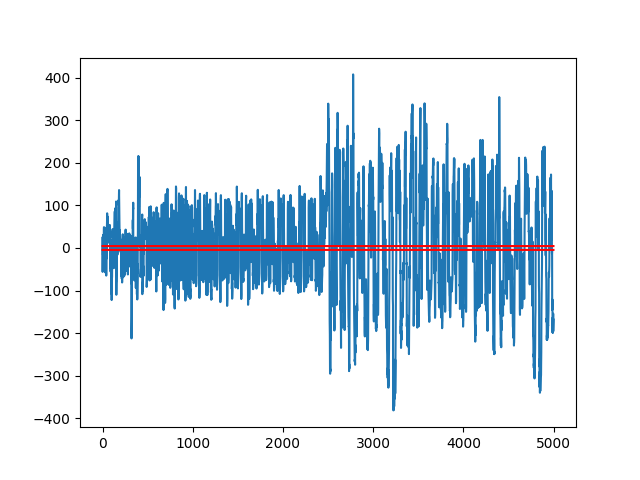

In [11]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
plt.plot(t)
plt.plot([4.5]*trace_array.shape[1], color='red')
plt.plot([-4.5]*trace_array_fixednc.shape[1], color='red')

plt.show()